<h1>Function to Deteriorate Real Runs with Swap and Replacement</h1>
<p>This script:</p>
<ol>
    <li>Import a run and the qrels (both in TREC format);</li>
    <li>Assess the run;</li>
    <li>Deteriorate or improve the assessed topic by removing/adding and swapping relevant documents;</li>
    <li>Mix replacements and swaps in both directions: better and worse;</li>
</ol>

In [1]:
# Import libraries
import pytrec_eval
import numpy
import pickle
import collections
import operator
import repro_eval
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from repro_eval.Evaluator import RpdEvaluator
from repro_eval.util import arp, arp_scores, print_base_adv, print_simple_line, trim
import pandas as pd
import time

In [2]:
from deterioration_functions import deteriorate_run, colormap_ktu, colormap_rbo, colormap_rmse, colormap_n_rmse, colormap_pvalues


<h3>Parameters</h3>

In [3]:
# Path to input ranking and qrels (here we consider a single topic)
# Run Name
run_name = 'BM25'
# Path to the run
# run_file_path = './data/real_runs/run_' + run_name + '.txt'
run_file_path = '../../data/core18/run_baseline_timo/run_timo_321_363'
# Qrels
# qrels_file_path = './data/real_runs/qrels_common_core_2018.txt'
qrels_file_path = '../../data/core18/qrels/qrels_common_core_2018_321_363.txt'

In [4]:
# Ratio: percentage of topics we want to modify
# Float in [0, 1]
ratio = 1

# Location: on which rank positions we want to replace documents and swap documents
# Source: we pick a document from the source, [s_1 s_2] (rank positions start from 1)
source = [1, 10]
# Destination: we move a document to the destination, [d_1 d_2] (rank positions start from 1)
# Documents are replaced in the destination
destination = [11, 20]

# Bolean paramenter
# True: prints some text output for each topic
verbose = False


<h3>Import the original Run</h3>

In [5]:
# Import the original run
# The run is a nested dictionary with: key: topic ids, value: a dictionary
# The nested dictionary has: key: doc ids, value: doc scores
with open(run_file_path, 'r') as f_run:
    run_orig = pytrec_eval.parse_run(f_run)

# Import the qrels
# The qrels is a nested dictionary with: key: topic ids, value: a dictionary
# The nested dictionary has: key: doc ids, value: relevance labels
with open(qrels_file_path, 'r') as f_qrel:
    qrels = pytrec_eval.parse_qrel(f_qrel)

<h3>Deterioration Loop</h3>

In [6]:
# Number of iterations: corresponds to the number of swaps
# In this case is the size of the interval
max_n_iterations = round((source[1] - source[0] + 1) / 2)
# Iteration step, i.e. step of numbers of replacements and swaps
iteration_step = 1

# Save the in a dictionary where each item is a RpdEvaluator object
# key: pair (s, r, m) where s is the number of swaps, r the number of replacement and m is the mode
rpd_eval_dictionary = {}

In [7]:
# Swap and replacement values
swaps_replacement_values = range(0, (max_n_iterations + 1), iteration_step)
# Number of iterations
n_iterations = len(swaps_replacement_values)

In [ ]:
def deteriorate_run(run_file_path, qrels_file_path, ratio, source, destination, 
                                mode, number_swaps, number_replacements, verbose):
    
    
    # Quantity: number of documents to replace plus number of documents to swaps
    # Not possible to have an 'all' option in this case
    quantity = number_swaps + number_replacements


    # Check that ratio is a float in [0, 1]
    if (ratio < 0) or (ratio > 1):
        print('Ratio should be a number in [0, 1]')

    # Convert source and destination lists to numpy arrays
    source = numpy.array(source)
    destination = numpy.array(destination)

    # Sort the start and end indexes of source and destination
    source.sort()
    destination.sort()

    # Check that the source and the destination do not overlap, otherwise retun an error
    # Note that source and destination can be swapped, i.e. source can be closer to the bottom of the ranking
    # and destination can be closer to the top of the ranking
    if min(source[1], destination[1]) - max(source[0], destination[0]) >= 0:
        print('Source and destination intervals can not overlap. Change the source and destination intervals.')

    # Check that quantity is either 'all' or an integer greater than 0
    if (quantity != 'all'):
        # If quantity is a string
        if isinstance(quantity, str):
            print('Quantity can assume only the string value \'all\'.')

        # If quantity is a number
        elif (quantity < 0):
            print('Quantity should be an integer >= 1.')


    # Subtract -1 to source and destination, since the index are expressed starting from 1
    # while in python arrays we start from 0
    source = numpy.array(source) - 1
    destination = numpy.array(destination) - 1 

    # Quantity: number of documents to move/replace, or move/replace all of them
    # either an int (number of swaps) or 'all'
    # quantity = 'all'

    # check that the quantity is < source and destination ranges
    if (quantity != 'all'):
        # then the source and destination range should be > than the quantity
        # otherwise there are not enough documents to move
        if quantity > (source[1] - source[0] + 1):
            print('Source interval does not contain enough documents to be moved. Reduce the quantity or increase the source range.')

        if quantity > (destination[1] - destination[0] + 1):
            print('Destination interval does not contain enough documents to be moved. Reduce the quantity or increase the destination range.')

    # Import the run
    # The run is a nested dictionary with: key: topic ids, value: a dictionary
    # The nested dictionary has: key: doc ids, value: doc scores
    with open(run_file_path, 'r') as f_run:
        run_orig = pytrec_eval.parse_run(f_run)

    # Import the qrels
    # The qrels is a nested dictionary with: key: topic ids, value: a dictionary
    # The nested dictionary has: key: doc ids, value: relevance labels
    with open(qrels_file_path, 'r') as f_qrel:
        qrels = pytrec_eval.parse_qrel(f_qrel)
        
    # Initialize the modified run
    modified_run = collections.defaultdict(dict)
    
    # Get the list of topic ids
    topic_ids = numpy.array(list(run_orig.keys()))
    # Select a random subset of topics to be modified
    # shuffle the array
    numpy.random.shuffle(topic_ids)
    # compute the number of topics to modify
    num_topics_mod = round(numpy.size(topic_ids, 0) * ratio)
    
    print(topic_ids)
    
    # topics which need to be modified
    for current_topic_id in topic_ids[0:num_topics_mod]:
        
        if verbose:
            print('Processing topic: %s - modified' % current_topic_id)

        # Get the list of document ids and scores for the given topic id
        # This is represented as a list of tuples (doc_id, score)
        current_ranking = list(run_orig[current_topic_id].items())

        # Sort the ranking as trec_eval
        # sort the tuples, score descending, doc_id descending
        # this is the same ordering used by trec_eval
        current_ranking.sort(key = operator.itemgetter(0), reverse = True)         # doc_id descending
        current_ranking.sort(key = operator.itemgetter(1), reverse = True)         # score descending

        # Assess the run:
        # Create a numpy array, where each element corresponds to the relvance label of the document in that rank position
        # -1 stands for unjudged documents
        # Length of the ranking
        ranking_length = len(current_ranking)
        # Initialize and empty array
        assessed_ranking = numpy.empty((ranking_length, ))
        # Populate the assessed ranking
        # For each rank position
        for r in range(ranking_length):
            # get the doc id at this rank position
            current_doc_id = current_ranking[r][0]
            # get the relevance grade for this documents
            # returns -1 if a document is unjudged
            current_doc_label = qrels[current_topic_id].get(current_doc_id, -1)
            # print(qrels.get(current_doc_id, -1))
            # populate the arrey
            assessed_ranking[r] = int(current_doc_label)

        # Find the position of relevant documents in the ranking
        bool_rel_doc_position = (assessed_ranking > 0)
        # vector of 0 and 1, where 1 means relevant and 0 everything else
        rel_doc_position = bool_rel_doc_position.astype(int)
        # actual rank position of relevant documents
        rel_doc_rank = numpy.argwhere(bool_rel_doc_position)[:, 0]
        # actual rank position of not relevant documents
        notrel_doc_rank = numpy.argwhere(~bool_rel_doc_position)[:, 0]

        # Create a copy of the current ranking
        # The score is copied as a string
        modified_ranking = numpy.array(current_ranking)

        # 1) Worse mode means that:
        # Swap: relevant documents at the beginning of the ranking (source) are swapped 
        # with non relevant documents at the end of the ranking (destination)
        # Replacement: relevant documents in the source are replaced with non relevant documents
        if (mode == 'worse'):

            # Check if there are enough document to move
            # Number of relevant documents in the source range
            num_relevant_source = numpy.sum(rel_doc_position[source[0]:(source[1] + 1)])
            # Number of not relevant documents in the destination
            num_notrel_destination = (destination[1] - destination[0] + 1) - numpy.sum(rel_doc_position[destination[0]:(destination[1] + 1)])

            # Set the current quantity to the specified quantity
            current_quantity = quantity
            # Set the current number of swaps and replacements to the current quantities
            current_swaps = number_swaps
            current_replacements = number_replacements


            # Check if there are relevant documents in the source range
            if num_relevant_source > 0:

                # 1) Check if there are enough not relevant documents to be swapped with the relevant documents
                if (current_swaps > num_notrel_destination):
                    if verbose:
                        print('\tTopic %s: there are less than %i not relevant documents in [%i, %i], decrease the number of swaps to %i.' % (current_topic_id, number_swaps, (destination[0] + 1), (destination[1] + 1), num_notrel_destination))
                    # The number of relevant documents I can move is equal to the number of not relevant documents
                    current_swaps = num_notrel_destination
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements   

                # 2) Check if there are not enough relevant document to move and replace
                if (num_relevant_source < current_quantity):
                    if verbose:
                        print('\tTopic %s: there are %i relevant documents in [%i, %i], decrease the number of documents to swap and replace.' % (current_topic_id, num_relevant_source, (source[0] + 1), (source[1] + 1)))
                    # The maximum number of documents that can be moved and replaced
                    # I want to keep the ratio of swaps/replacements fixed
                    # Given that the number of swaps should be less than num_notrel_destination
                    # Coefficient to keep the same ratio
                    coefficient_ratio = int(round((number_swaps * num_relevant_source) / (number_swaps + number_replacements)))
                    # Get the minimum bewteen the number which gives the correct ratio and 
                    # the maximum number of swaps which can be done
                    current_swaps = min(coefficient_ratio, num_notrel_destination)
                    # All the other actions will be replacements actions (can not do otherwise)
                    current_replacements = num_relevant_source - current_swaps
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements

                if verbose:
                    # Print the 'true' number of swaps and replacements
                    print('\tNumber of Swaps: %i, Number of Replacement: %i'% (current_swaps, current_replacements))

                # Rank positions of relevant documents (source)
                rel_doc_rank_source = rel_doc_rank[numpy.logical_and(rel_doc_rank >= source[0], rel_doc_rank <= source[1])]
                # Get a random shuffle of rank positions of relevant documents
                numpy.random.shuffle(rel_doc_rank_source)

                # Swap documents and replace documents
                # 1) Start with swap
                # If the number of swaps is > 0
                if current_swaps > 0:

                    # select the relevant documents to swap
                    rel_doc_swap = rel_doc_rank_source[0:current_swaps]

                    # rank positions of not relevant documents (destination)
                    notrel_doc_rank_destination = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= destination[0], notrel_doc_rank <= destination[1])]
                    # get a random subset with the size equal to current_quantity
                    numpy.random.shuffle(notrel_doc_rank_destination)
                    # select the not relevant documents to swap
                    notrel_doc_swap = notrel_doc_rank_destination[0:current_swaps]

                    # swap the documents
                    for k in range(current_swaps):
                        # Document id of the document to be swapped in the source interval
                        source_doc_id = current_ranking[rel_doc_swap[k]][0]
                        # Document id of the document to be swapped in the destination interval
                        destination_doc_id = current_ranking[notrel_doc_swap[k]][0]
                        # Modify the ranking, move the destination document (not relevant)
                        modified_ranking[rel_doc_swap[k]][0] = destination_doc_id
                        # Modify the ranking, move the source document (relevant)
                        modified_ranking[notrel_doc_swap[k]][0] = source_doc_id

                # 2) Replace documents
                # Replace documents
                # If the number of repacements is > 0
                if current_replacements > 0:
                    # Select the relevant documents to replace
                    rel_doc_replace = rel_doc_rank_source[current_swaps:current_quantity]

                    # replace the documents
                    for k in range(current_replacements):
                        # Document id of the document to be replaced in the location interval
                        location_doc_id = current_ranking[rel_doc_replace[k]][0]
                        # Modify the ranking, replace the relevant document with a fake non relevant
                        modified_ranking[rel_doc_replace[k]][0] = 'fake' + location_doc_id

            # if there are no relevant documents, there is nothing to do
            else:
                if verbose:
                    print('\tTopic %s: no relevant documents in [%i, %i].' % (current_topic_id, source[0], source[1]))

            # Add the modified ranking to the dictionary
            # for each element of the new ranking
            for row in modified_ranking:
                # get the current document id
                current_doc_id = row[0]
                # get the current document score
                current_score = row[1]
                # add the element (doc_id, score) to the run dictionary
                # the score has to be converted to float
                modified_run[current_topic_id][current_doc_id] = float(current_score)


        # 2) Better mode means that:
        # Swap: non relevant documents at the beginning of the ranking (source) are swapped 
        # with relevant documents at the end of the ranking (destination)
        # Replacement: non relevant documents in the source are replaced with relevant documents
        elif (mode == 'better'):

            # For swap I just need to swap source and destination
            # Check if there are enough document to move
            # Number of relevant documents in the destination range
            num_relevant_destination = numpy.sum(rel_doc_position[destination[0]:(destination[1] + 1)])
            # Number of not relevant documents in the source
            num_notrel_source = (source[1] - source[0] + 1) - numpy.sum(rel_doc_position[source[0]:(source[1] + 1)])

            # Set the current quantity to the specified quantity
            current_quantity = quantity
            # Set the current number of swaps and replacements to the current quantities
            current_swaps = number_swaps
            current_replacements = number_replacements

            # Check if there are not relevant documents in the source range
            if num_notrel_source > 0:

                # 1) Check if there are enough relevant documents to be swapped with the non relevant documents
                if (current_swaps > num_relevant_destination):
                    if verbose:
                        print('\tTopic %s: there are less than %i relevant documents in [%i, %i], decrease the number of swaps to %i.' % (current_topic_id, number_swaps, (destination[0] + 1), (destination[1] + 1), num_relevant_destination))
                    # The number of relevant documents I can move is equal to the number of not relevant documents
                    current_swaps = num_relevant_destination
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements


                # 2) Check if there are enough relevant documents that were not retrieved
                # We need to check if we have enough relevant documents (not retrieved) to replace the not relevant ones
                # rank positions of relevant documents (in the whole ranking) rel_doc_rank
                # Get doc ids of the relevant documents retreived in the ranking
                rel_doc_retrieved = [current_ranking[k][0] for k in rel_doc_rank]
                # List of relevant documents ids in the qrels
                rel_doc_qrels = [doc_id for doc_id, label in qrels[current_topic_id].items() if label > 0]
                # List of relevant documents that are not retrieved
                # Note the the difference between sets is not symmetric
                # Anyway rel_doc_qrels always includes rel_doc_retrieved
                rel_doc_not_retrieved = list(set(rel_doc_qrels) - set(rel_doc_retrieved))
                # Number of relevant documents not retrieved
                num_rel_doc_not_retrieved = len(rel_doc_not_retrieved)
                # Check if the number of replacements is smaller than the number relevant not retrieved
                if (current_replacements > num_rel_doc_not_retrieved):
                    if verbose:
                        print('\tTopic %s: there are just %i relevant documents not retrieved. Decrease the number of replacements.' % (current_topic_id, num_rel_doc_not_retrieved))
                    # Decrease the number of replacements to the greatest possible number
                    current_replacements = num_rel_doc_not_retrieved
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements                


                # 3) Check if there are not enough non-relevant documents to move and replace
                if (num_notrel_source < current_quantity):
                    if verbose:
                        print('\tTopic %s: there are %i non relevant documents in [%i, %i], decrease the number of documents to swap and replace.' % (current_topic_id, num_notrel_source, (source[0] + 1), (source[1] + 1)))
                    # The maximum number of documents that can be moved and replaced
                    # I want to keep the ratio of swaps/replacements fixed
                    # Given that the number of swaps should be less than num_relevant_destination
                    # And the number of replacements should be less than the number of not retrieved relevant documents
                    # Coefficient to keep the same ratio
                    coefficient_ratio = int(round((number_swaps * num_notrel_source) / (number_swaps + number_replacements)))
                    # Get the minimum bewteen the number which gives the correct ratio and 
                    # the maximum number of swaps which can be done
                    current_swaps = min(coefficient_ratio, num_relevant_destination)
                    # All the other actions will be replacements actions (can not do otherwise)
                    current_replacements = num_notrel_source - current_swaps
                    # Get the maximum number of replacements that can be done
                    current_replacements = min(current_replacements, num_rel_doc_not_retrieved)
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements

                if verbose:
                    # Print the 'true' number of swaps and replacements
                    print('\tNumber of Swaps: %i, Number of Replacement: %i'% (current_swaps, current_replacements))

                # Rank positions of non relevant documents (source)
                # not_rel_doc_rank_source = rel_doc_rank[numpy.logical_and(rel_doc_rank >= source[0], rel_doc_rank <= source[1])]
                notrel_doc_rank_source = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= source[0], notrel_doc_rank <= source[1])]

                # Get a random shuffle of rank positions of non relevant documents
                numpy.random.shuffle(notrel_doc_rank_source)

                # Swap documents and replace documents
                # 1) Start with swap
                # If the number of swaps is > 0
                if current_swaps > 0:

                    # select the relevant documents to swap
                    notrel_doc_swap = notrel_doc_rank_source[0:current_swaps]
                    # rank positions of relevant documents (destination)
                    #notrel_doc_rank_destination = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= destination[0], notrel_doc_rank <= destination[1])]
                    rel_doc_rank_destination = rel_doc_rank[numpy.logical_and(rel_doc_rank >= destination[0], rel_doc_rank <= destination[1])]
                    # get a random subset with the size equal to current_quantity
                    numpy.random.shuffle(rel_doc_rank_destination)
                    # select the not relevant documents to swap
                    rel_doc_swap = rel_doc_rank_destination[0:current_swaps]

                    # swap the documents
                    for k in range(current_swaps):
                        # Document id of the document to be swapped in the source interval
                        source_doc_id = current_ranking[notrel_doc_swap[k]][0]
                        # Document id of the document to be swapped in the destination interval
                        destination_doc_id = current_ranking[rel_doc_swap[k]][0]
                        # Modify the ranking, move the destination document (not relevant)
                        modified_ranking[notrel_doc_swap[k]][0] = destination_doc_id
                        # Modify the ranking, move the source document (relevant)
                        modified_ranking[rel_doc_swap[k]][0] = source_doc_id

                # 2) Replace documents
                # Replace documents
                # If the number of repacements is > 0
                if current_replacements > 0:

                    # select the not relevant documents to replace
                    notrel_doc_replace = notrel_doc_rank_source[current_swaps:current_quantity]

                    # replace the documents
                    for k in range(current_replacements):
                        # Document id of the document to be replaced in the location interval
                        # source_doc_id = current_ranking[notrel_doc_replace[k]][0]
                        # Modify the ranking, replace the non relevant document with a relevant document
                        modified_ranking[notrel_doc_replace[k]][0] = rel_doc_not_retrieved[k]

            # if there are no relevant documents, there is nothing to do
            else:
                if verbose:
                    print('\tTopic %s: no non-relevant documents in [%i, %i].' % (current_topic_id, source[0], source[1]))

            # Add the modified ranking to the dictionary
            # for each element of the new ranking
            for row in modified_ranking:
                # get the current document id
                current_doc_id = row[0]
                # get the current document score
                current_score = row[1]
                # add the element (doc_id, score) to the run dictionary
                # the score has to be converted to float
                modified_run[current_topic_id][current_doc_id] = float(current_score)

        # 3) Betterworse mode means that:
        # Swap (better): non relevant documents at the beginning of the ranking (source) are swapped 
        # with relevant documents at the end of the ranking (destination)
        # Replacement (worse): relevant documents in the source are replaced with non relevant documents
        elif (mode == 'betterworse'):

            # For swap I just need to swap source and destination
            # Check if there are enough documents to move
            # Number of relevant documents in the destination range
            num_relevant_destination = numpy.sum(rel_doc_position[destination[0]:(destination[1] + 1)])
            # Number of not relevant documents in the source
            num_notrel_source = (source[1] - source[0] + 1) - numpy.sum(rel_doc_position[source[0]:(source[1] + 1)])
            # Number of relevant documents in the source interval
            num_relevant_source = numpy.sum(rel_doc_position[source[0]:(source[1] + 1)])
            
            # Set the current quantity to the specified quantity
            current_quantity = quantity
            # Set the current number of swaps and replacements to the current quantities
            current_swaps = number_swaps
            current_replacements = number_replacements

            # Check if there are not relevant documents in the source range
            # and if there are relevant documents in the source reange
            if (num_notrel_source > 0) or (num_relevant_source > 0):

                # 1) Check if there are enough relevant documents to be swapped with the non relevant documents
                if (current_swaps > num_relevant_destination):
                    if verbose:
                        print('\tTopic %s: there are less than %i relevant documents in [%i, %i], decrease the number of swaps to %i.' % (current_topic_id, number_swaps, (destination[0] + 1), (destination[1] + 1), num_relevant_destination))
                    # The number of relevant documents I can move is equal to the number of not relevant documents
                    current_swaps = num_relevant_destination
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements            

                # 3) Check if there are not enough non-relevant documents to move
                if (num_notrel_source < current_swaps):
                    if verbose:
                        print('\tTopic %s: there are %i non relevant documents in [%i, %i], decrease the number of documents to swap.' % (current_topic_id, num_notrel_source, (source[0] + 1), (source[1] + 1)))
                    # The maximum number of documents that can be swapped
                    # corresponds to the number of not relevant documents in the source interval
                    current_swaps = num_notrel_source
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements
                    
                # 3) Check if there are not enough relevant document to replace
                if (num_relevant_source < current_replacements):
                    if verbose:
                        print('\tTopic %s: there are %i relevant documents in [%i, %i], decrease the number of documents to replace.' % (current_topic_id, num_relevant_source, (source[0] + 1), (source[1] + 1)))
                    # The maximum number of documents that can be replaced
                    # corresponds to the number of relevant documents
                    current_replacements = num_relevant_source
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements

                if verbose:
                    # Print the 'true' number of swaps and replacements
                    print('\tNumber of Swaps: %i, Number of Replacement: %i'% (current_swaps, current_replacements))

                # Rank positions of non relevant documents (source)
                notrel_doc_rank_source = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= source[0], notrel_doc_rank <= source[1])]

                # Get a random shuffle of rank positions of non relevant documents
                numpy.random.shuffle(notrel_doc_rank_source)

                # Swap documents and replace documents
                # 1) Start with swap
                # If the number of swaps is > 0
                if current_swaps > 0:

                    # select the relevant documents to swap
                    notrel_doc_swap = notrel_doc_rank_source[0:current_swaps]
                    # rank positions of relevant documents (destination)
                    #notrel_doc_rank_destination = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= destination[0], notrel_doc_rank <= destination[1])]
                    rel_doc_rank_destination = rel_doc_rank[numpy.logical_and(rel_doc_rank >= destination[0], rel_doc_rank <= destination[1])]
                    # get a random subset with the size equal to current_quantity
                    numpy.random.shuffle(rel_doc_rank_destination)
                    # select the not relevant documents to swap
                    rel_doc_swap = rel_doc_rank_destination[0:current_swaps]

                    # swap the documents
                    for k in range(current_swaps):
                        # Document id of the document to be swapped in the source interval
                        source_doc_id = current_ranking[notrel_doc_swap[k]][0]
                        # Document id of the document to be swapped in the destination interval
                        destination_doc_id = current_ranking[rel_doc_swap[k]][0]
                        # Modify the ranking, move the destination document (not relevant)
                        modified_ranking[notrel_doc_swap[k]][0] = destination_doc_id
                        # Modify the ranking, move the source document (relevant)
                        modified_ranking[rel_doc_swap[k]][0] = source_doc_id

                # 2) Replace documents
                # Replace documents
                # If the number of repacements is > 0
                if current_replacements > 0:
                    # Rank positions of relevant documents (source)
                    rel_doc_rank_source = rel_doc_rank[numpy.logical_and(rel_doc_rank >= source[0], rel_doc_rank <= source[1])]
                    # Get a random shuffle of rank positions of relevant documents
                    numpy.random.shuffle(rel_doc_rank_source)
                    # Select the relevant documents to replace
                    rel_doc_replace = rel_doc_rank_source[0:current_replacements]

                    # replace the documents
                    for k in range(current_replacements):
                        # Document id of the document to be replaced in the location interval
                        location_doc_id = current_ranking[rel_doc_replace[k]][0]
                        # Modify the ranking, replace the relevant document with a fake non relevant
                        modified_ranking[rel_doc_replace[k]][0] = 'fake' + location_doc_id

            # if there are no relevant documents, there is nothing to do
            else:
                if verbose:
                    print('\tTopic %s: no non-relevant documents in [%i, %i].' % (current_topic_id, source[0], source[1]))

            # Add the modified ranking to the dictionary
            # for each element of the new ranking
            for row in modified_ranking:
                # get the current document id
                current_doc_id = row[0]
                # get the current document score
                current_score = row[1]
                # add the element (doc_id, score) to the run dictionary
                # the score has to be converted to float
                modified_run[current_topic_id][current_doc_id] = float(current_score)
                

        # 4) Worsebetter mode means that:
        # Swap (worse): relevant documents at the beginning of the ranking (source) are swapped 
        # with not relevant documents at the end of the ranking (destination)
        # Replacement (better): not relevant documents in the source are replaced with relevant documents
        elif (mode == 'worsebetter'):

            # Check if there are enough document to move
            # Number of relevant documents in the source range
            num_relevant_source = numpy.sum(rel_doc_position[source[0]:(source[1] + 1)])
            # Number of not relevant documents in the source
            num_notrel_source = (source[1] - source[0] + 1) - numpy.sum(rel_doc_position[source[0]:(source[1] + 1)])
            # Number of not relevant documents in the destination
            num_notrel_destination = (destination[1] - destination[0] + 1) - numpy.sum(rel_doc_position[destination[0]:(destination[1] + 1)])

            # Set the current quantity to the specified quantity
            current_quantity = quantity
            # Set the current number of swaps and replacements to the current quantities
            current_swaps = number_swaps
            current_replacements = number_replacements
            

            # Check if there are relevant documents in the source range
            if (num_relevant_source > 0) or (num_notrel_source > 0):
                
                # 1) Check if there are enough not relevant documents to be swapped with the relevant documents
                if (current_swaps > num_notrel_destination):
                    if verbose:
                        print('\tTopic %s: there are less than %i not relevant documents in [%i, %i], decrease the number of swaps to %i.' % (current_topic_id, number_swaps, (destination[0] + 1), (destination[1] + 1), num_notrel_destination))
                    # The number of relevant documents I can move is equal to the number of not relevant documents
                    current_swaps = num_notrel_destination
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements   

                # 2) Check if there are not enough relevant document to move
                if (num_relevant_source < current_swaps):
                    if verbose:
                        print('\tTopic %s: there are %i relevant documents in [%i, %i], decrease the number of documents to swap.' % (current_topic_id, num_relevant_source, (source[0] + 1), (source[1] + 1)))
                    # The maximum number of documents that can be moved and replaced
                    # is the number of relevant documents in the source interval
                    current_swaps = num_relevant_source
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements
                
                # 3) Check if there are enough relevant documents in the source interval
                if (num_notrel_source < current_replacements):
                    if verbose:
                        print('\tTopic %s: there are %i relevant documents in [%i, %i], decrease the number of documents to replace.' % (current_topic_id, num_relevant_source, (source[0] + 1), (source[1] + 1)))
                    # The maximum number of documents that can be replaced
                    # corresponds to the number of not relevant documents
                    current_replacements = num_notrel_source
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements
                
                # 4) Check if there are enough relevant documents that were not retrieved
                # We need to check if we have enough relevant documents (not retrieved) to replace the not relevant ones
                # rank positions of relevant documents (in the whole ranking) rel_doc_rank
                # Get doc ids of the relevant documents retreived in the ranking
                rel_doc_retrieved = [current_ranking[k][0] for k in rel_doc_rank]
                # List of relevant documents ids in the qrels
                rel_doc_qrels = [doc_id for doc_id, label in qrels[current_topic_id].items() if label > 0]
                # List of relevant documents that are not retrieved
                # Note the the difference between sets is not symmetric
                # Anyway rel_doc_qrels always includes rel_doc_retrieved
                rel_doc_not_retrieved = list(set(rel_doc_qrels) - set(rel_doc_retrieved))
                # Number of relevant documents not retrieved
                num_rel_doc_not_retrieved = len(rel_doc_not_retrieved)
                # Check if the number of replacements is smaller than the number relevant not retrieved
                if (current_replacements > num_rel_doc_not_retrieved):
                    if verbose:
                        print('\tTopic %s: there are just %i relevant documents not retrieved. Decrease the number of replacements.' % (current_topic_id, num_rel_doc_not_retrieved))
                    # Decrease the number of replacements to the greatest possible number
                    current_replacements = num_rel_doc_not_retrieved
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements

                if verbose:
                    # Print the 'true' number of swaps and replacements
                    print('\tNumber of Swaps: %i, Number of Replacement: %i'% (current_swaps, current_replacements))

                # Rank positions of relevant documents (source)
                rel_doc_rank_source = rel_doc_rank[numpy.logical_and(rel_doc_rank >= source[0], rel_doc_rank <= source[1])]
                # Get a random shuffle of rank positions of relevant documents
                numpy.random.shuffle(rel_doc_rank_source)

                # Swap documents and replace documents
                # 1) Start with swap
                # If the number of swaps is > 0
                if current_swaps > 0:

                    # select the relevant documents to swap
                    rel_doc_swap = rel_doc_rank_source[0:current_swaps]

                    # rank positions of not relevant documents (destination)
                    notrel_doc_rank_destination = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= destination[0], notrel_doc_rank <= destination[1])]
                    # get a random subset with the size equal to current_quantity
                    numpy.random.shuffle(notrel_doc_rank_destination)
                    # select the not relevant documents to swap
                    notrel_doc_swap = notrel_doc_rank_destination[0:current_swaps]

                    # swap the documents
                    for k in range(current_swaps):
                        # Document id of the document to be swapped in the source interval
                        source_doc_id = current_ranking[rel_doc_swap[k]][0]
                        # Document id of the document to be swapped in the destination interval
                        destination_doc_id = current_ranking[notrel_doc_swap[k]][0]
                        # Modify the ranking, move the destination document (not relevant)
                        modified_ranking[rel_doc_swap[k]][0] = destination_doc_id
                        # Modify the ranking, move the source document (relevant)
                        modified_ranking[notrel_doc_swap[k]][0] = source_doc_id

                # 2) Replace documents
                # Replace documents
                # If the number of repacements is > 0
                if current_replacements > 0:
                    
                    # Rank positions of non relevant documents (source)
                    notrel_doc_rank_source = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= source[0], notrel_doc_rank <= source[1])]
                    # Get a random shuffle of rank positions of non relevant documents
                    numpy.random.shuffle(notrel_doc_rank_source)
                    # select the not relevant documents to replace
                    notrel_doc_replace = notrel_doc_rank_source[0:current_replacements]

                    # replace the documents
                    for k in range(current_replacements):
                        # Document id of the document to be replaced in the location interval
                        # source_doc_id = current_ranking[notrel_doc_replace[k]][0]
                        # Modify the ranking, replace the non relevant document with a relevant document
                        modified_ranking[notrel_doc_replace[k]][0] = rel_doc_not_retrieved[k]

            # if there are no relevant documents, there is nothing to do
            else:
                if verbose:
                    print('\tTopic %s: no relevant documents in [%i, %i].' % (current_topic_id, source[0], source[1]))

            # Add the modified ranking to the dictionary
            # for each element of the new ranking
            for row in modified_ranking:
                # get the current document id
                current_doc_id = row[0]
                # get the current document score
                current_score = row[1]
                # add the element (doc_id, score) to the run dictionary
                # the score has to be converted to float
                modified_run[current_topic_id][current_doc_id] = float(current_score)                
                
                print('topic: %s score: %s doc_id %s' % (str(current_topic_id), str(current_score), str(current_doc_id)))

                
        
        
    # topics which do not need to be modified
    for current_topic_id in topic_ids[num_topics_mod:]:
        
        if verbose:
            print('Processing topic: %s - copied' % current_topic_id)

        # Copy the original ranking
        modified_run[current_topic_id] = run_orig[current_topic_id]
    
    # Return the modified run
    return modified_run
    

In [ ]:
def deteriorate_run(run_file_path, qrels_file_path, ratio, source, destination, 
                                mode, number_swaps, number_replacements, verbose):
    
    
    # Quantity: number of documents to replace plus number of documents to swaps
    # Not possible to have an 'all' option in this case
    quantity = number_swaps + number_replacements


    # Check that ratio is a float in [0, 1]
    if (ratio < 0) or (ratio > 1):
        print('Ratio should be a number in [0, 1]')

    # Convert source and destination lists to numpy arrays
    source = numpy.array(source)
    destination = numpy.array(destination)

    # Sort the start and end indexes of source and destination
    source.sort()
    destination.sort()

    # Check that the source and the destination do not overlap, otherwise retun an error
    # Note that source and destination can be swapped, i.e. source can be closer to the bottom of the ranking
    # and destination can be closer to the top of the ranking
    if min(source[1], destination[1]) - max(source[0], destination[0]) >= 0:
        print('Source and destination intervals can not overlap. Change the source and destination intervals.')

    # Check that quantity is either 'all' or an integer greater than 0
    if (quantity != 'all'):
        # If quantity is a string
        if isinstance(quantity, str):
            print('Quantity can assume only the string value \'all\'.')

        # If quantity is a number
        elif (quantity < 0):
            print('Quantity should be an integer >= 1.')


    # Subtract -1 to source and destination, since the index are expressed starting from 1
    # while in python arrays we start from 0
    source = numpy.array(source) - 1
    destination = numpy.array(destination) - 1 

    # Quantity: number of documents to move/replace, or move/replace all of them
    # either an int (number of swaps) or 'all'
    # quantity = 'all'

    # check that the quantity is < source and destination ranges
    if (quantity != 'all'):
        # then the source and destination range should be > than the quantity
        # otherwise there are not enough documents to move
        if quantity > (source[1] - source[0] + 1):
            print('Source interval does not contain enough documents to be moved. Reduce the quantity or increase the source range.')

        if quantity > (destination[1] - destination[0] + 1):
            print('Destination interval does not contain enough documents to be moved. Reduce the quantity or increase the destination range.')

    # Import the run
    # The run is a nested dictionary with: key: topic ids, value: a dictionary
    # The nested dictionary has: key: doc ids, value: doc scores
    with open(run_file_path, 'r') as f_run:
        run_orig = pytrec_eval.parse_run(f_run)

    # Import the qrels
    # The qrels is a nested dictionary with: key: topic ids, value: a dictionary
    # The nested dictionary has: key: doc ids, value: relevance labels
    with open(qrels_file_path, 'r') as f_qrel:
        qrels = pytrec_eval.parse_qrel(f_qrel)
        
    # Initialize the modified run
    modified_run = collections.defaultdict(dict)
    
    # Get the list of topic ids
    topic_ids = numpy.array(list(run_orig.keys()))
    # Select a random subset of topics to be modified
    # shuffle the array
    numpy.random.shuffle(topic_ids)
    # compute the number of topics to modify
    num_topics_mod = round(numpy.size(topic_ids, 0) * ratio)
    
    print(topic_ids)
    
    # topics which need to be modified
    for current_topic_id in topic_ids[0:num_topics_mod]:
        
        if verbose:
            print('Processing topic: %s - modified' % current_topic_id)

        # Get the list of document ids and scores for the given topic id
        # This is represented as a list of tuples (doc_id, score)
        current_ranking = list(run_orig[current_topic_id].items())

        # Sort the ranking as trec_eval
        # sort the tuples, score descending, doc_id descending
        # this is the same ordering used by trec_eval
        current_ranking.sort(key = operator.itemgetter(0), reverse = True)         # doc_id descending
        current_ranking.sort(key = operator.itemgetter(1), reverse = True)         # score descending

        # Assess the run:
        # Create a numpy array, where each element corresponds to the relvance label of the document in that rank position
        # -1 stands for unjudged documents
        # Length of the ranking
        ranking_length = len(current_ranking)
        # Initialize and empty array
        assessed_ranking = numpy.empty((ranking_length, ))
        # Populate the assessed ranking
        # For each rank position
        for r in range(ranking_length):
            # get the doc id at this rank position
            current_doc_id = current_ranking[r][0]
            # get the relevance grade for this documents
            # returns -1 if a document is unjudged
            current_doc_label = qrels[current_topic_id].get(current_doc_id, -1)
            # print(qrels.get(current_doc_id, -1))
            # populate the arrey
            assessed_ranking[r] = int(current_doc_label)

        # Find the position of relevant documents in the ranking
        bool_rel_doc_position = (assessed_ranking > 0)
        # vector of 0 and 1, where 1 means relevant and 0 everything else
        rel_doc_position = bool_rel_doc_position.astype(int)
        # actual rank position of relevant documents
        rel_doc_rank = numpy.argwhere(bool_rel_doc_position)[:, 0]
        # actual rank position of not relevant documents
        notrel_doc_rank = numpy.argwhere(~bool_rel_doc_position)[:, 0]

        # Create a copy of the current ranking
        # The score is copied as a string
        modified_ranking = numpy.array(current_ranking)

        # 1) Worse mode means that:
        # Swap: relevant documents at the beginning of the ranking (source) are swapped 
        # with non relevant documents at the end of the ranking (destination)
        # Replacement: relevant documents in the source are replaced with non relevant documents
        if (mode == 'worse'):

            # Check if there are enough document to move
            # Number of relevant documents in the source range
            num_relevant_source = numpy.sum(rel_doc_position[source[0]:(source[1] + 1)])
            # Number of not relevant documents in the destination
            num_notrel_destination = (destination[1] - destination[0] + 1) - numpy.sum(rel_doc_position[destination[0]:(destination[1] + 1)])

            # Set the current quantity to the specified quantity
            current_quantity = quantity
            # Set the current number of swaps and replacements to the current quantities
            current_swaps = number_swaps
            current_replacements = number_replacements


            # Check if there are relevant documents in the source range
            if num_relevant_source > 0:

                # 1) Check if there are enough not relevant documents to be swapped with the relevant documents
                if (current_swaps > num_notrel_destination):
                    if verbose:
                        print('\tTopic %s: there are less than %i not relevant documents in [%i, %i], decrease the number of swaps to %i.' % (current_topic_id, number_swaps, (destination[0] + 1), (destination[1] + 1), num_notrel_destination))
                    # The number of relevant documents I can move is equal to the number of not relevant documents
                    current_swaps = num_notrel_destination
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements   

                # 2) Check if there are not enough relevant document to move and replace
                if (num_relevant_source < current_quantity):
                    if verbose:
                        print('\tTopic %s: there are %i relevant documents in [%i, %i], decrease the number of documents to swap and replace.' % (current_topic_id, num_relevant_source, (source[0] + 1), (source[1] + 1)))
                    # The maximum number of documents that can be moved and replaced
                    # I want to keep the ratio of swaps/replacements fixed
                    # Given that the number of swaps should be less than num_notrel_destination
                    # Coefficient to keep the same ratio
                    coefficient_ratio = int(round((number_swaps * num_relevant_source) / (number_swaps + number_replacements)))
                    # Get the minimum bewteen the number which gives the correct ratio and 
                    # the maximum number of swaps which can be done
                    current_swaps = min(coefficient_ratio, num_notrel_destination)
                    # All the other actions will be replacements actions (can not do otherwise)
                    current_replacements = num_relevant_source - current_swaps
                    # Update the current quantity
                    current_quantity = current_swaps + current_replacements

                if verbose:
                    # Print the 'true' number of swaps and replacements
                    print('\tNumber of Swaps: %i, Number of Replacement: %i'% (current_swaps, current_replacements))

                # Rank positions of relevant documents (source)
                rel_doc_rank_source = rel_doc_rank[numpy.logical_and(rel_doc_rank >= source[0], rel_doc_rank <= source[1])]
                # Get a random shuffle of rank positions of relevant documents
                numpy.random.shuffle(rel_doc_rank_source)

                # Swap documents and replace documents
                # 1) Start with swap
                # If the number of swaps is > 0
                if current_swaps > 0:

                    # select the relevant documents to swap
                    rel_doc_swap = rel_doc_rank_source[0:current_swaps]

                    # rank positions of not relevant documents (destination)
                    notrel_doc_rank_destination = notrel_doc_rank[numpy.logical_and(notrel_doc_rank >= destination[0], notrel_doc_rank <= destination[1])]
                    # get a random subset with the size equal to current_quantity
                    numpy.random.shuffle(notrel_doc_rank_destination)
                    # select the not relevant documents to swap
                    notrel_doc_swap = notrel_doc_rank_destination[0:current_swaps]

                    # swap the documents
                    for k in range(current_swaps):
                        # Document id of the document to be swapped in the source interval
                        source_doc_id = current_ranking[rel_doc_swap[k]][0]
                        # Document id of the document to be swapped in the destination interval
                        destination_doc_id = current_ranking[notrel_doc_swap[k]][0]
                        # Modify the ranking, move the destination document (not relevant)
                        modified_ranking[rel_doc_swap[k]][0] = destination_doc_id
                        # Modify the ranking, move the source document (relevant)
                        modified_ranking[notrel_doc_swap[k]][0] = source_doc_id

                # 2) Replace documents
                # Replace documents
                # If the number of repacements is > 0
                if current_replacements > 0:
                    # Select the relevant documents to replace
                    rel_doc_replace = rel_doc_rank_source[current_swaps:current_quantity]

                    # replace the documents
                    for k in range(current_replacements):
                        # Document id of the document to be replaced in the location interval
                        location_doc_id = current_ranking[rel_doc_replace[k]][0]
                        # Modify the ranking, replace the relevant document with a fake non relevant
                        modified_ranking[rel_doc_replace[k]][0] = 'fake' + location_doc_id

            # if there are no relevant documents, there is nothing to do
            else:
                if verbose:
                    print('\tTopic %s: no relevant documents in [%i, %i].' % (current_topic_id, source[0], source[1]))

            # Add the modified ranking to the dictionary
            # for each element of the new ranking
            for row in modified_ranking:
                # get the current document id
                current_doc_id = row[0]
                # get the current document score
                current_score = row[1]
                # add the element (doc_id, score) to the run dictionary
                # the score has to be converted to float
                modified_run[current_topic_id][current_doc_id] = float(current_score)


        
    # topics which do not need to be modified
    for current_topic_id in topic_ids[num_topics_mod:]:
        
        if verbose:
            print('Processing topic: %s - copied' % current_topic_id)

        # Copy the original ranking
        modified_run[current_topic_id] = run_orig[current_topic_id]
    
    # Return the modified run
    return modified_run
    

In [8]:
start_time = time.time()

# For each number of swaps
for number_swaps in swaps_replacement_values:
    # for each number of replacement
    for number_replacements in swaps_replacement_values:
        # for all the possible modalities
        for mode in ['worse', 'better', 'worsebetter', 'betterworse']:
            
            # print('Number of Swaps: %d, Number of replacements: %d, Mode: %s' % (number_swaps, number_replacements, mode))
            
            # Deteriorate the original run
            deteriorated_run = deteriorate_run(run_file_path, qrels_file_path, ratio, source, destination,
                                                           mode, number_swaps, number_replacements, verbose)
            
            # Initialize and rpd object
            rpd_eval = RpdEvaluator()
            # Set all the field of the rpd object
            rpd_eval.run_b_orig = run_orig
            rpd_eval.run_b_rep = deteriorated_run
            
            rpd_eval.rel_eval = pytrec_eval.RelevanceEvaluator(qrels, pytrec_eval.supported_measures)

            rpd_eval.trim()
            rpd_eval.evaluate()
            # Save all the objects in a dictionary
            rpd_eval_dictionary[(number_swaps, number_replacements, mode)] = rpd_eval
            
print('--- %s minutes ---' % ((time.time() - start_time) / 60))

--- 0.006151719888051351 minutes ---


<h2>Compute Evaluation Measures</h2>
<ol>
    <li>Ranking Level Measures - Kendall's tau and RBO</li>
    <li>Effectiveness Level Measures - RMSE, normalized RMSE</li>
    <li>Statistical Level Measures - p values</li>    
</ol>

<h3>Kendall's Tau Union</h3>

In [9]:
# Kendall's tau Union
# Initialize a dictionary to store the measure computation
start_time = time.time()
ktu = {}
# Compute Kendall's tau union
for number_swaps in swaps_replacement_values:
    
    for number_replacements in swaps_replacement_values:
        
        for mode in ['worse', 'better', 'worsebetter', 'betterworse']:
            
            # Get the run
            rpd_run = rpd_eval_dictionary[(number_swaps, number_replacements, mode)]
            
            ktu[(number_swaps, number_replacements, mode)] = rpd_run.ktau_union()
            
            del rpd_run
            
print('--- %s minutes ---' % ((time.time() - start_time) / 60))

--- 0.002158451080322266 minutes ---


In [10]:
# File name
file_name = './measure_scores/' + run_name +'/' + run_name + '_ktu.p'

# Save scores in pickle format
with open(file_name, 'wb') as f:
    pickle.dump(ktu, f)

/Users/tjz514/Documents/uni/2021/repro_follow_up/experiments/python/paper_experiments/deterioration_functions/colormap_ktu.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)
/Users/tjz514/Documents/uni/2021/repro_follow_up/experiments/python/paper_experiments/deterioration_functions/colormap_ktu.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels, rotation = 0)


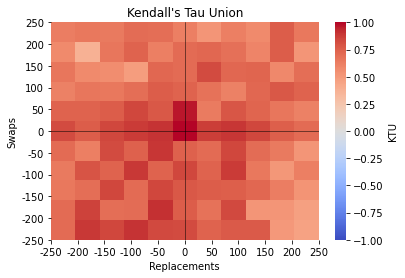

In [11]:
colormap_ktu(swaps_replacement_values, 250, 50, ktu, -1, 1, run_name, './', True)


In [ ]:
del ktu

<h3>Rank Biased Overlap</h3>

In [ ]:
# Rank Biased Overlap
# Initialize a dictionary to store the measure computation
start_time = time.time()
rbo = {}
# Compute Rank Biased Overlap
for number_swaps in swaps_replacement_values:
    
    for number_replacements in swaps_replacement_values:
        
        for mode in ['worse', 'better', 'worsebetter', 'betterworse']:
            
            # Get the run
            rpd_run = rpd_eval_dictionary[(number_swaps, number_replacements, mode)]
            
            rbo[(number_swaps, number_replacements, mode)] = rpd_run.rbo()
            
print('--- %s minutes ---' % ((time.time() - start_time) / 60))

In [ ]:
# File name
file_name = './measure_scores/' + run_name +'/' + run_name + '_rbo.p'

# Save scores in pickle format
with open(file_name, 'wb') as f:
    pickle.dump(rbo, f)

In [ ]:
print(rbo[(0, 0, 'worse')])

In [ ]:
colormap_rbo(swaps_replacement_values, 250, 50, rbo, 0, 1, run_name, './', True)

In [ ]:
del rbo

<h3>Compute RMSE</h3>

In [ ]:
# RMSE
start_time = time.time()

rmse = {}
# Compute RMSE
for number_swaps in swaps_replacement_values:
    
    for number_replacements in swaps_replacement_values:
        
        for mode in ['worse', 'better', 'worsebetter', 'betterworse']:
            
            # Get the run
            rpd_run = rpd_eval_dictionary[(number_swaps, number_replacements, mode)]
            
            rmse[(number_swaps, number_replacements, mode)] = rpd_run.rmse()

print('--- %s minutes ---' % ((time.time() - start_time) / 60))

In [ ]:
# File name
file_name = './measure_scores/' + run_name +'/' + run_name + '_rmse.p'

# Save scores in pickle format
with open(file_name, 'wb') as f:
    pickle.dump(rmse, f)

In [ ]:
print(rmse[(0, 0, 'better')])

In [ ]:
# Print the color map
colormap_rmse(swaps_replacement_values, 250, 50, rmse, 0, 1, run_name, 'baseline', 'ndcg', './', True)


In [ ]:
colormap_rmse(swaps_replacement_values, 250, 50, rmse, 0, 1, run_name, 'baseline', 'P_10', './', True)


In [ ]:
colormap_rmse(swaps_replacement_values, 250, 50, rmse, 0, 1, run_name, 'baseline', 'map', './', True)


In [ ]:
del rmse

<h3>Compute Normalized RMSE</h3>

In [ ]:
start_time = time.time()
# RMSE
n_rmse = {}
# Compute RMSE
for number_swaps in swaps_replacement_values:
    
    for number_replacements in swaps_replacement_values:
        
        for mode in ['worse', 'better', 'worsebetter', 'betterworse']:
            
            # Get the run
            rpd_run = rpd_eval_dictionary[(number_swaps, number_replacements, mode)]
            
            n_rmse[(number_swaps, number_replacements, mode)] = rpd_run.nrmse()
            
print('--- %s minutes ---' % ((time.time() - start_time) / 60))

In [ ]:
# File name
file_name = './measure_scores/' + run_name +'/' + run_name + '_nrmse.p'

# Save scores in pickle format
with open(file_name, 'wb') as f:
    pickle.dump(n_rmse, f)

In [ ]:
colormap_n_rmse(swaps_replacement_values, 250, 50, n_rmse, 0, 1, run_name, 'baseline', 'ndcg', './', True)

In [ ]:
colormap_n_rmse(swaps_replacement_values, 250, 50, n_rmse, 0, 1, run_name, 'baseline', 'P_10', './', True)

In [ ]:
colormap_n_rmse(swaps_replacement_values, 250, 50, n_rmse, 0, 1, run_name, 'baseline', 'map', './', True)

In [ ]:
del n_rmse

<h3>Compute p-values</h3>

In [ ]:
# Compute t-test
pvalue = {}
# Compute ER
for number_swaps in swaps_replacement_values:
    
    for number_replacements in swaps_replacement_values:
        
        for mode in ['worse', 'better', 'worsebetter', 'betterworse']:
            
            # Get the run
            rpd_run = rpd_eval_dictionary[(number_swaps, number_replacements, mode)]
            
            pvalue[(number_swaps, number_replacements, mode)] = rpd_run.ttest()

In [ ]:
# File name
file_name = './measure_scores/' + run_name +'/' + run_name + '_pvalue.p'

# Save scores in pickle format
with open(file_name, 'wb') as f:
    pickle.dump(pvalue, f)

In [ ]:
print(pvalue[(0, 0, 'better')])

In [ ]:
colormap_pvalues(swaps_replacement_values, 250, 50, pvalue, run_name, 'baseline', 'P_10', './', True)


In [ ]:
colormap_pvalues(swaps_replacement_values, 250, 50, pvalue, run_name, 'baseline', 'ndcg', './', True)


In [ ]:
colormap_pvalues(swaps_replacement_values, 250, 50, pvalue, run_name, 'baseline', 'map', './', True)
